ECE 447: Performance
===

Updated by 
 Dr. Chris Takahashi

Authored by Prof. Eric Klavins &copy; 2019, University of Washington


# Code

In [0]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline
#comment out for light mode
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

# Performance Metrics

So far we have been looking at safety issues like sensitivity, disturbance rejection, and noise. Here, we look at how well the system achieves its goal of tracking its input.

<img src="https://raw.githubusercontent.com/klavins/ECE447/master/images/performance.png" width=70%>

In the above figure, we define

- $T_s$: Settling time ($\delta \approx 0.02$)
- $T_p$: Peak time
- $T_r$: Rise time
- $M_p$: Peak response
- P.0.: $M_p - 1$ -- the percent overshoot

The alternative definition of rise time is $T_{r_1}$, which is used when the system does not actually get to an output of 1.

Using the response of the archetypal 2nd order system, we can find these metrics in terms of the parameters $\zeta$ and $\omega$. 

# First peak

Peak time
---

Recall that for system
$$
T(s) = \frac{\omega^2}{s^2 + 2 \zeta \omega s + \omega^2},
$$
the step response is

$$
y(t) = 1 - \frac{1}{\beta} e^{-\zeta \omega t} \sin(\omega \beta t + \theta),
$$
where  $\beta = \sqrt{1- \zeta^2}$ and $\theta = \cos^{-1} \zeta .$

The overshoot can be found by looking at the first critical point of $y(t)$, which is obtained by taking the derivative $\dot y(t)$, which we have already found to be 

$$
\dot y = \frac{\omega}{\beta} e^{-\zeta \omega t} \sin(\omega \beta t).
$$

This is zero when $\sin( \omega\beta  t) = 0$ or when

$$
\omega\beta  t = 0, \pi, 2\pi, \dots
$$

the first peak occurs at $\pi$ or at time

$$
T_p = \frac{\pi}{\omega\beta} = \frac{\pi}{\omega\sqrt{1-\zeta^2}} .
$$

Max response
---

The maximum response is $y(T_p)$ or

$$
M_p = 1 - \frac{1}{\beta} e^{-\zeta \omega T_p} \sin(\pi + \theta).
$$

Since
$$
\sin(\pi + \theta) = -\sin(\theta) = -\beta
$$

we get

$$
M_p = 1 + \frac{1}{\beta} e^{-\zeta \omega \frac{\pi}{\omega\beta}} \beta.
$$

or

$$
1 + e^{-\frac{\zeta \pi}{\beta}}
$$

Percent Overshoot
---

The percent overshoot is just $M_p-1$ or 

$$
\mathrm{P.O.} = e^{-\zeta \frac{\pi}{\beta}}
$$

Analysis
---

- $M_p$ does not depend on $\omega$, although $T_p$ does.

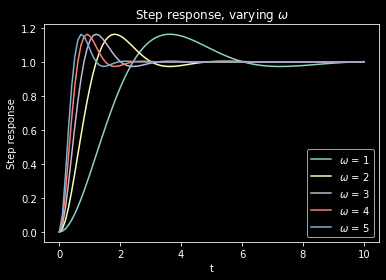

In [19]:
#
# Fixed zeta, varying omega
#
var("w z t b tau theta", real=True, positive=True)
y = 1 - (1/b) * exp(-z*w*t) * sin(w * b * t + theta)
y = y.subs(b,sqrt(1-z**2)).subs(theta,acos(z))
tvals = np.linspace(0,10,100)
for omega in [1,2,3,4,5]:
    f = lambdify(t,y.subs(z,0.5).subs(w,omega),'numpy')
    plt.plot(tvals,f(tvals),label="$\omega$ = %d" % omega)
plt.xlabel("t")
plt.ylabel("Step response")
plt.title("Step response, varying $\omega$")
plt.legend();

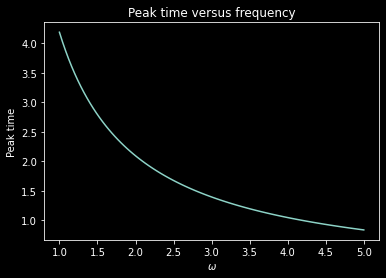

In [20]:
ovals = np.linspace(1,5,100);
plt.plot(ovals,np.pi/(ovals*(1-0.5**2)));
plt.xlabel("$\omega$")
plt.ylabel("Peak time")
plt.title("Peak time versus frequency");

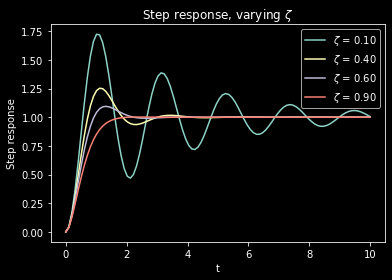

In [21]:
tvals = np.linspace(0,10,100)
for zeta in [0.1,0.4,0.6,0.9]:
    f = lambdify(t,y.subs(z,zeta).subs(w,3),'numpy')
    plt.plot(tvals,f(tvals),label="$\zeta$ = %.2f" % zeta)
plt.xlabel("t")
plt.ylabel("Step response")
plt.title("Step response, varying $\zeta$")
plt.legend();

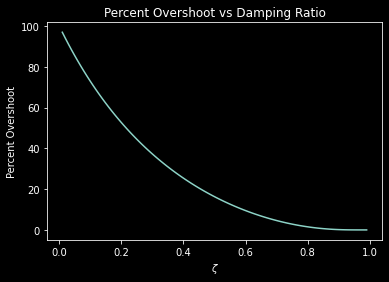

In [22]:
zvals = np.linspace(0.01,0.99,100);
plt.plot(zvals,100*np.exp(-zvals*np.pi/np.sqrt(1-zvals**2)));
plt.xlabel("$\zeta$")
plt.ylabel("Percent Overshoot")
plt.title("Percent Overshoot vs Damping Ratio");

# Settling time

For settling time, we want the time $T_s$ at which 

$$
1 - \delta < y(T_s) < 1 + \delta
$$

for all $t > T_s$. This occurs when 

$$
e^{-\zeta \omega T_s} \leq \delta
$$

or when

$$
-\zeta \omega T_s = \ln \delta
$$

or

$$
T_s = - \frac{\ln \delta}{\zeta \omega}
$$

we usually take $\delta = 0.02$ so that $-\ln \delta \approx 4$ and

$$
T_s = \frac{4}{\zeta\omega}
$$

We call $\tau \triangleq \frac{1}{\zeta\omega}$ the **time constant** of the system so that 

$$
T_s = 4 \tau .
$$

You can see that we

> Settle in faster and overshoot less when you increase damping

# Summary

<img src="https://raw.githubusercontent.com/klavins/ECE447/master/images/performance-summary.png" width=70%>

| Name | Symbol | Formula &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |
|------|--------|---------|
| Peak time | $T_p$ | $\frac{\pi}{\omega\sqrt{1-\zeta^2}}$ |
| Peak response | $M_p$ | $1 + e^{-\frac{\zeta \pi}{\beta}}$ |
| Percent overshoot | P.O. | $e^{-\frac{\zeta \pi}{\beta}}$ |
| Settling time | $T_s$ | $\frac{4}{\zeta\omega}$ |


# Design Example

Suppose we would like to design the following system 

<img src="https://raw.githubusercontent.com/klavins/ECE447/master/images/performance-control-example.png" width=70%>

where $a$ and $K$ are tunable.

The transfer function for the whole system is

$$
T(s) = \frac{K}{s^2 + as + K}
$$

Mapping this onto the archetypal system, we get that

$$
\omega = \sqrt{K}
$$

and

$$
2 \zeta \omega = a \;\; \Rightarrow \;\; \zeta = \frac{a}{2\sqrt{K}}.
$$

**Example Goal**: Say we want $T_s = 5s$ and P.O. = 25%. 

For the settling time we need:

$$
\frac{4}{\zeta\omega} = 5 \;\; \Rightarrow \;\; \frac{4}{\frac{a}{2\sqrt{K}} \sqrt{K}} = 5 \;\; \Rightarrow \;\; a = \frac{8}{5}
$$

For the percent overshoot, we need

$$
e^{-\frac{\zeta \pi}{\beta}} = 0.25 \;\; \Rightarrow \frac{\zeta\pi}{\omega} = -\ln(1.4)
$$

or

$$
\frac{
  \frac{a}{s\sqrt{K}}\pi
}{
  \sqrt{1 - \frac{a^2 \pi^2}{4K}}
} = \ln(1.4) \;\; \Rightarrow \;\; K \approx 
$$

In [0]:
var("a K w z b s")
var("t", positive=True, real=True)
w = sqrt(K)
z = a / ( 2*sqrt(K))
b = sqrt(1-z**2)

In [24]:
# Settling time
aval = solve(4/(z*w)-5,a)[0]
aval

8/5

In [25]:
# Percent overshoot
Kval = solve(exp(-z*pi/b)-0.25,K)[0].subs(a,aval)
Kval

3.92676615283581

In [26]:
# Compute step response
T = (1/s) * K / ( s**2 + a*s + K )
T = T.subs(a,aval).subs(K,Kval)
y = inverse_laplace_transform(T,s,t)
y

⎛     0.8⋅t                                                                   
⎝1.0⋅ℯ      - 0.441271200305303⋅sin(1.81294405673088⋅t) - 1.0⋅cos(1.8129440567

       ⎞  -0.8⋅t
3088⋅t)⎠⋅ℯ      

/usr/local/lib/python3.6/dist-packages/sympy/plotting/plot.py:890: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax.spines['left'].set_smart_bounds(True)
/usr/local/lib/python3.6/dist-packages/sympy/plotting/plot.py:891: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  self.ax.spines['bottom'].set_smart_bounds(False)


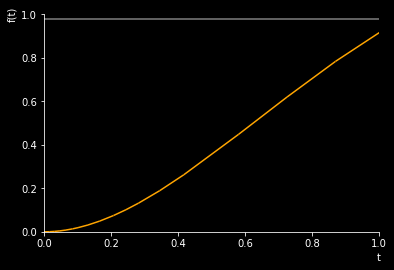

In [27]:
plots = plotting.plot(y,1.25,0.98, 1.02, (t,0,10),show=False);
plots.extend(plotting.plot_parametric(5,t,(t,0,1.25),show=False))
plots[0].line_color = 'orange'
plots[1].line_color = 'gray'
plots[2].line_color = 'gray'
plots[3].line_color = 'gray'
plots[4].line_color = 'gray'
plots.show()

In [0]:
aaa =  lambdify(t,y)

In [29]:
aaa(3)

0.9696687794637543